In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns
%matplotlib inline

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.utils import shuffle
import statsmodels.api as sm

In [3]:
# Load Dataset with all columns
# Making the data columns datetime objects with the parse_dates attribute
bikeshare_machine = pd.read_csv('less_bikeshare_lat_lon.csv', 
                        parse_dates=['Start date', 'End date', 'start_date_short', 'end_date_short'])
# Removing the Unnamed column
bikeshare_machine.drop('Unnamed: 0', 1, inplace=True)

In [5]:
# creating a list of columns which will be used to create the list of columns to keep for the machine
# learning piece
list(bikeshare_machine.columns)

['Start date',
 'End date',
 'start_station',
 'start_station_code',
 'end_station',
 'end_station_code',
 'Member Type',
 'start_date_short',
 'end_date_short',
 'time_diff',
 'season',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'hum',
 'windspeed',
 'start_lat',
 'start_lon',
 'end_lat',
 'end_lon',
 'miles']

In [6]:
# Selecting the columns that are needed for the analysis
included_cols = ['start_station',
                 'end_station',
                 'Member Type',
                 'time_diff',
                 'season',
                 'mnth',
                 'holiday',
                 'weekday',
                 'workingday',
                 'weathersit',
                 'temp',
                 'hum',
                 'windspeed',
                 'miles']
# Subsetting the dataset so that only the columns above are included
bikeshare_machine = bikeshare_machine[included_cols]
bikeshare_machine.head()

,start_station,end_station,Member Type,time_diff,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,miles
0,11th & Kenyon St NW,Calvert St & Woodley Pl NW,Registered,10.0,3,6,0,4,1,1,0.696667,0.434167,0.185312,1.264341
1,Lamont & Mt Pleasant NW,Adams Mill & Columbia Rd NW,Registered,5.0,3,6,0,4,1,1,0.696667,0.434167,0.185312,0.651763
2,Massachusetts Ave & Dupont Circle NW,Adams Mill & Columbia Rd NW,Casual,10.0,3,6,0,4,1,1,0.696667,0.434167,0.185312,0.890094
3,10th St & Constitution Ave NW,14th & D St NW / Ronald Reagan Building,Casual,30.0,3,6,0,4,1,1,0.696667,0.434167,0.185312,0.319015
4,10th St & Constitution Ave NW,14th & D St NW / Ronald Reagan Building,Casual,30.0,3,6,0,4,1,1,0.696667,0.434167,0.185312,0.319015


In [7]:
# Make categorical data for columns like month, holiday, etc.
bikeshare_machine['season'] = bikeshare_machine['season'].astype('category')
bikeshare_machine['mnth'] = bikeshare_machine['mnth'].astype('category')
bikeshare_machine['holiday'] = bikeshare_machine['holiday'].astype('category')
bikeshare_machine['weekday'] = bikeshare_machine['weekday'].astype('category')
bikeshare_machine['workingday'] = bikeshare_machine['workingday'].astype('category')
bikeshare_machine['weathersit'] = bikeshare_machine['weathersit'].astype('category')
bikeshare_machine['Member Type'] = bikeshare_machine['Member Type'].astype('category')
bikeshare_machine['start_station'] = bikeshare_machine['start_station'].astype('category')
bikeshare_machine['end_station'] = bikeshare_machine['end_station'].astype('category')

In [8]:
# Update columns names for the dataset
col_names = ['start_station', 'end_station','member_type','time_diff','season','month','holiday',
             'weekday','work_day','weather_cat','temperature','humidity','windspeed','miles']
bikeshare_machine.columns = col_names

In [9]:
# Standardization of windspeed, humidity, and temperature were not all the same
# Values were changed back to their original values (not scaled)
tmin = -8
tmax = 39
hum_max = 100
wind_max = 67
bikeshare_machine['temp'] = bikeshare_machine['temperature'] * (tmax - tmin) + tmin
bikeshare_machine['hum'] = bikeshare_machine['humidity'] * 100
bikeshare_machine['wind'] = bikeshare_machine['windspeed'] * 67

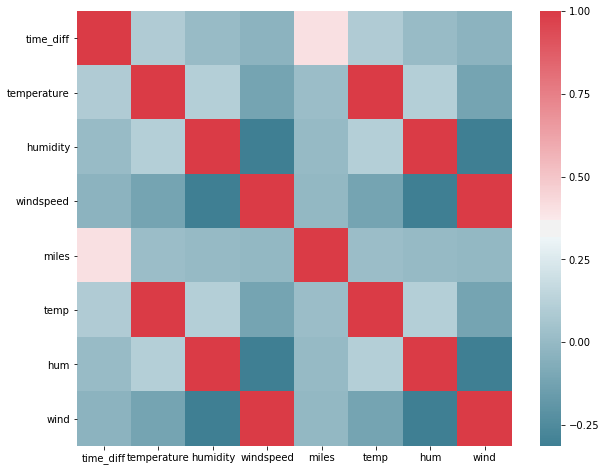

In [10]:
# Checking the correlations between continuous variables
corr = bikeshare_machine.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [11]:
# Turn categorical data into dummy variables. Dropping first dummy for the category variables that have 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['member_type','holiday','work_day'], drop_first=True)
# Turning categorical data into dummy variables. Not dropping the first dummy for categorical data with more
# than 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['start_station','end_station','season','month','weekday','weather_cat'])
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,miles,temp,hum,wind,member_type_Registered,holiday_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
0,10.0,0.696667,0.434167,0.185312,1.264341,24.743349,43.4167,12.415904,1,0,...,0,0,0,0,1,0,0,1,0,0
1,5.0,0.696667,0.434167,0.185312,0.651763,24.743349,43.4167,12.415904,1,0,...,0,0,0,0,1,0,0,1,0,0
2,10.0,0.696667,0.434167,0.185312,0.890094,24.743349,43.4167,12.415904,0,0,...,0,0,0,0,1,0,0,1,0,0
3,30.0,0.696667,0.434167,0.185312,0.319015,24.743349,43.4167,12.415904,0,0,...,0,0,0,0,1,0,0,1,0,0
4,30.0,0.696667,0.434167,0.185312,0.319015,24.743349,43.4167,12.415904,0,0,...,0,0,0,0,1,0,0,1,0,0


In [12]:
bikeshare_machine = shuffle(bikeshare_machine)
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,miles,temp,hum,wind,member_type_Registered,holiday_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
447480,4.0,0.766667,0.424167,0.200258,0.692797,28.033349,42.4167,13.417286,1,0,...,0,0,0,1,0,0,0,1,0,0
710173,10.0,0.395000,0.758750,0.057225,0.647695,10.565000,75.8750,3.834075,1,0,...,0,1,0,0,0,0,0,1,0,0
894914,21.0,0.390000,0.416667,0.261817,2.237717,10.330000,41.6667,17.541739,1,0,...,0,0,1,0,0,0,0,1,0,0
727871,14.0,0.400833,0.683750,0.135571,1.212738,10.839151,68.3750,9.083257,1,0,...,0,0,1,0,0,0,0,1,0,0
876497,2.0,0.342500,0.835833,0.123767,0.376474,8.097500,83.5833,8.292389,1,0,...,0,0,1,0,0,0,0,1,0,0


### Model 1 - Remove Some Variables that are correlated

In [14]:
# Leave workday, drop weekdays, leave season, drop month
# Workday overlaps with workday/not workday and months overlap with seasons
remove_cols = ['weekday_0', 'weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6', 
              'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9',
              'month_10','month_11','month_12','temperature','humidity','windspeed', 'time_diff']
X1 = np.matrix(bikeshare_machine.drop(remove_cols, 1))
y1 = bikeshare_machine['time_diff']

In [15]:
# Split the data into training and testing sets and check the shape
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.25, random_state=17)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((827346, 274), (275782, 274), (827346,), (275782,))

In [15]:
# Fit model
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
pred1 = model1.predict(X1_test)
cvscores_model1 = cross_val_score(model1, X1_train, y1_train, cv=5)
model1_r = model1.score(X1_test, y1_test)
model1_mse = mean_squared_error(y1_test, pred1)
model1_rmse = np.sqrt(model1_mse)
adjustedr1 = 1 - (1-model1_r)*(len(y1_test)-1)/(len(y1_test)-X1_test.shape[1]-1)

In [17]:
cvscores_model1, model1_r, adjustedr1, model1_mse, model1_rmse

(array([ 0.41211439,  0.41572634,  0.41169114,  0.41067691,  0.41145773]),
 0.41212562308799727,
 0.41154096433423104,
 81.087373124317409,
 9.0048527541719086)

In [18]:
model1_sm = sm.OLS(y1_train, X1_train).fit()
model1_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     2154.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        11:25:09   Log-Likelihood:            -2.9898e+06
No. Observations:              827346   AIC:                         5.980e+06
Df Residuals:                  827075   BIC:                         5.983e+06
Df Model:                         270                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.1719      0.014    439.943      0.000       6.144       6.199
x2             0.0536      0.002     24.471      0.000       0.049       0.058
x3             0.0021      0.001      2.076      0.038       0.000       0.004
x4            -0.0082      0.002     -3.801      0.000      -0.012      -0.004
x5           -11.2069      0.029   -390.251      0.000     -11.263     -11.151
x6            -0.5861      0.067     -8.769      0.000      -0.717      -0.455
x7            -1.7275      0.023    -74.370      0.000      -1.773      -1.682
x8            -0.6485      0.214     -3.034      0.002      -1.067      -0.230
x9            -0.9885      0.095    -10.445      0.000      -1.174      -0.803
x10            3.6129      0.099     36.461      0.000       3.419       3.807
x11           -1.0296      0.240     -4.283      0.000      -1.501      -0.558
x12           -1.7112      0.100    -17.042      0.000      -1.908      -1.514
x13            1.2327      0.314      3.926      0.000       0.617       1.848
x14           -0.0676      0.338     -0.200      0.841      -0.729       0.594
x15           -1.5594      0.109    -14.331      0.000      -1.773      -1.346
x16           -0.8133      0.109     -7.458      0.000      -1.027      -0.600
x17            0.7086      0.103      6.913      0.000       0.508       0.910
x18            3.3963      0.112     30.236      0.000       3.176       3.616
x19           -1.0276      0.126     -8.179      0.000      -1.274      -0.781
x20            1.4801      0.107     13.870      0.000       1.271       1.689
x21           -2.2828      0.092    -24.719      0.000      -2.464      -2.102
x22           -1.0788      0.096    -11.284      0.000      -1.266      -0.891
x23           -0.6525      0.085     -7.640      0.000      -0.820      -0.485
x24           -1.2777      0.082    -15.599      0.000      -1.438      -1.117
x25           -2.1397      0.133    -16.136      0.000      -2.400      -1.880
x26           -1.8062      0.230     -7.845      0.000      -2.257      -1.355
x27            2.9869      0.232     12.893      0.000       2.533       3.441
x28           -0.2241      0.077     -2.917      0.004      -0.375      -0.074
x29           -1.7448      0.273     -6.390      0.000      -2.280      -1.210
x30           -2.0132      0.089    -22.500      0.000      -2.189      -1.838
x31           -0.5209      0.079     -6.565      0.000      -0.676      -0.365
x32            0.4340      0.107      4.049      0.000       0.224       0.644
x33           -0.2925      0.094     -3.125      0.002      -0.476      -0.109
x34            0.1752      0.196      0.892      0.372      -0.210       0.560
x35            1.7030      0.137     12.397      0.000       1.434       1.972
x36           -0.2538      0.186     -1.361      0.174      -0.619       0.112
x3

### Model 2 - Try reverse of Model 1

In [21]:
# Drop workday, leave weekdays, drop season, leave month
# Workday overlaps with workday/not workday and months overlap with seasons
remove_cols = ['work_day_1','season_1', 'season_2', 'season_3', 'season_4',
               'temperature','humidity','windspeed', 'time_diff']
X2 = bikeshare_machine.drop(remove_cols, 1)
y2 = bikeshare_machine['time_diff']

In [22]:
# Split the data into training and testing sets and check the shape
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state=17)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((827346, 288), (275782, 288), (827346,), (275782,))

In [21]:
# Fit model
model2 = LinearRegression()
model2.fit(X2_train, y2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
pred2 = model2.predict(X2_test)
cvscores_model2 = cross_val_score(model2, X2_train, y2_train, cv=5)
model2_r = model2.score(X2_test, y2_test)
model2_mse = mean_squared_error(y2_test, pred2)
model2_rmse = np.sqrt(model2_mse)
adjustedr2 = 1 - (1-model2_r)*(len(y2_test)-1)/(len(y2_test)-X2_test.shape[1]-1)

In [23]:
cvscores_model2, model2_r, adjustedr2, model2_mse, model2_rmse

(array([ 0.41287843,  0.4162642 ,  0.41241191,  0.41133426,  0.41215003]),
 0.41288513297717189,
 0.41227136390970887,
 80.982611521849506,
 8.9990339215856672)

In [24]:
# Use statsmodel to check the statistical side of the model
model2_sm = sm.OLS(y2_train, X2_train).fit()
model2_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     2061.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        11:30:17   Log-Likelihood:            -2.9894e+06
No. Observations:              827346   AIC:                         5.979e+06
Df Residuals:                  827062   BIC:                         5.983e+06
Df Model:                         283                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
miles                                                                 6.1682      0.014    439.845      0.000       6.141       6.196
temp                                                                  0.0655      0.003     20.072      0.000       0.059       0.072
hum                                                                  -0.0040      0.001     -3.592      0.000      -0.006      -0.002
wind                                                                 -0.0189      0.002     -8.481      0.000      -0.023      -0.015
member_type_Registered                                              -11.1764      0.029   -389.050      0.000     -11.233     -11.120
holiday_1                                                             0.9690      0.068     14.149      0.000       0.835       1.103
start_station_10th & Monroe St NE                                    -0.6791      0.214     -3.179      0.001      -1.098      -0.260
start_station_10th & U St NW                                         -1.0222      0.095    -10.804      0.000      -1.208      -0.837
start_station_10th St & Constitution Ave NW                           3.5620      0.099     35.961      0.000       3.368       3.756
start_station_11th & H St NE                                         -0.9551      0.240     -3.974      0.000      -1.426      -0.484
start_station_11th & Kenyon St NW                                    -1.7290      0.100    -17.226      0.000      -1.926      -1.532
start_station_12th & Army Navy Dr                                     1.2017      0.314      3.829      0.000       0.587       1.817
start_station_12th & Newton St NE                                    -0.1406      0.337     -0.417      0.677      -0.802       0.521
start_station_13th & D St NE                                         -1.5831      0.109    -14.556      0.000      -1.796      -1.370
start_station_13th & H St NE                                         -0.8549      0.109     -7.843      0.000      -1.069      -0.641
start_station_13th St & New York Ave NW                               0.6635      0.102      6.475      0.000       0.463       0.864
start_station_14th & D St NW / Ronald Reagan Building                 3.3830      0.112     30.133      0.000       3.163       3.603
start_station_14th & D St SE                                         -1.0552      0.126     -8.402      0.000      -1.301      -0.809
start_station_14th & G St NW                                          1.4357      0.107     13.459      0.000       1.227       1.645
start_station_14th & Harvard St NW                                   -2.3137      0.092    -25.062      0.000      -2.495      -2.133
s

### Model 3 - All variables

In [26]:
# Keep all but time_diff
X3 = bikeshare_machine.drop('time_diff', 1)
y3 = bikeshare_machine['time_diff']

In [27]:
# Split the data into training and testing sets and check the shape
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.25, random_state=17)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

((827346, 296), (275782, 296), (827346,), (275782,))

In [14]:
# Fit model
model3 = LinearRegression()
model3.fit(X3_train, y3_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
pred3 = model3.predict(X3_test)
cvscores_model3 = cross_val_score(model3, X3_train, y3_train, cv=5)
model3_r = model3.score(X3_test, y3_test)
model3_mse = mean_squared_error(y3_test, pred3)
model3_rmse = np.sqrt(model3_mse)
adjustedr3 = 1 - (1-model3_r)*(len(y3_test)-1)/(len(y3_test)-X3_test.shape[1]-1)

In [16]:
cvscores_model3, model3_r, adjustedr3, model3_mse, model3_rmse

(array([ 0.41304442,  0.41408866,  0.41074035,  0.41855468,  0.41397845]),
 0.40980448214080378,
 0.40917033555102089,
 81.142606611456515,
 9.0079191055124657)

In [17]:
# Use statsmodel to check the statistical side of the model
model3_sm = sm.OLS(y3_train, X3_train).fit()
model3_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     2048.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        13:23:41   Log-Likelihood:            -2.9891e+06
No. Observations:              827346   AIC:                         5.979e+06
Df Residuals:                  827059   BIC:                         5.982e+06
Df Model:                         286                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
temperature                                                           2.9171      0.020    145.678      0.000       2.878       2.956
humidity                                                          -4.726e-05    1.1e-05     -4.295      0.000   -6.88e-05   -2.57e-05
windspeed                                                            -0.0003   3.34e-05     -9.438      0.000      -0.000      -0.000
miles                                                                 6.1794      0.014    440.579      0.000       6.152       6.207
temp                                                                  0.0070      0.003      2.065      0.039       0.000       0.014
hum                                                                  -0.0047      0.001     -4.295      0.000      -0.007      -0.003
wind                                                                 -0.0211      0.002     -9.438      0.000      -0.025      -0.017
member_type_Registered                                              -11.1842      0.029   -389.598      0.000     -11.240     -11.128
holiday_1                                                             3.5676      0.056     63.973      0.000       3.458       3.677
work_day_1                                                            2.5679      0.033     78.287      0.000       2.504       2.632
start_station_10th & Monroe St NE                                    -0.9162      0.214     -4.283      0.000      -1.336      -0.497
start_station_10th & U St NW                                         -1.1600      0.094    -12.351      0.000      -1.344      -0.976
start_station_10th St & Constitution Ave NW                           3.5715      0.099     36.113      0.000       3.378       3.765
start_station_11th & H St NE                                         -0.9567      0.235     -4.066      0.000      -1.418      -0.496
start_station_11th & Kenyon St NW                                    -1.8677      0.101    -18.538      0.000      -2.065      -1.670
start_station_12th & Army Navy Dr                                     1.6857      0.309      5.449      0.000       1.079       2.292
start_station_12th & Newton St NE                                    -0.6985      0.341     -2.048      0.041      -1.367      -0.030
start_station_13th & D St NE                                         -1.6922      0.108    -15.653      0.000      -1.904      -1.480
start_station_13th & H St NE                                         -0.9944      0.109     -9.158      0.000      -1.207      -0.782
start_station_13th St & New York Ave NW                               0.4584      0.102      4.486      0.000       0.258       0.659
s

### Model 4 - Ridge with Round 1

In [18]:
# Fit the model with 5 folds
alpha = np.arange(0.0001, 20, 25)
param_grid = {'alpha': alpha}
ridge1 = Ridge(fit_intercept=True)
ridge1_gs = GridSearchCV(ridge1, param_grid, cv=5)
ridge1_gs.fit(X1_train, y1_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [19]:
pred4 = ridge1_gs.predict(X1_test)
ridge1_r = ridge1_gs.score(X1_test, y1_test)
ridge1_mse = mean_squared_error(y1_test, pred4)
ridge1_rmse = np.sqrt(ridge1_mse)
adjustedr4 = 1 - (1-ridge1_r)*(len(y1_test)-1)/(len(y1_test)-X1_test.shape[1]-1)

In [20]:
ridge1_r, ridge1_mse, ridge1_rmse, adjustedr4

(0.41027552199246697,
 81.183231433922757,
 9.0101737737916441,
 0.40968902325750178)

In [23]:
# Fit the model with 5 folds
alpha = np.arange(0.0001, 20, 25)
param_grid = {'alpha': alpha}
ridge2 = Ridge(fit_intercept=True)
ridge2_gs = GridSearchCV(ridge2, param_grid, cv=5)
ridge2_gs.fit(X2_train, y2_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [24]:
pred5 = ridge2_gs.predict(X2_test)
ridge2_r = ridge2_gs.score(X2_test, y2_test)
ridge2_mse = mean_squared_error(y2_test, pred5)
ridge2_rmse = np.sqrt(ridge2_mse)
adjustedr5 = 1 - (1-ridge2_r)*(len(y2_test)-1)/(len(y2_test)-X2_test.shape[1]-1)

In [25]:
ridge2_r, ridge2_mse, ridge2_rmse, adjustedr5

(0.41088172418125835,
 81.099779831651333,
 9.0055416178956911,
 0.41026586075301952)

In [28]:
# Fit the model with 5 folds
alpha = np.arange(0.0001, 20, 25)
param_grid = {'alpha': alpha}
ridge3 = Ridge(fit_intercept=True)
ridge3_gs = GridSearchCV(ridge3, param_grid, cv=5)
ridge3_gs.fit(X3_train, y3_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [29]:
pred6 = ridge3_gs.predict(X3_test)
ridge3_r = ridge3_gs.score(X3_test, y3_test)
ridge3_mse = mean_squared_error(y3_test, pred6)
ridge3_rmse = np.sqrt(ridge3_mse)
adjustedr6 = 1 - (1-ridge3_r)*(len(y3_test)-1)/(len(y3_test)-X3_test.shape[1]-1)

In [31]:
ridge3_r, ridge3_mse, ridge3_rmse, adjustedr6

(0.41088610458610786,
 81.099176812048228,
 9.0055081373595023,
 0.41025312016574922)